<a href="https://colab.research.google.com/github/Ogawatatsuya41/bookers1/blob/main/09_01_hierarchical_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第9回: 階層クラスタリング
階層クラスタリングを使ってデータの教師無しクラスタリングを行います。


## ステップ0: Google Driveのマウントと作業フォルダへの移動  
Google Drive に配置したデータを読み込むための準備です。  
詳細については第二回の 02_01_graph.ipynb を参照してください。  

ここでは"マイドライブ/情報管理/09"を作業フォルダとします。

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# フォルダの移動には"%cd"を使用します。
# 作業フォルダへ移動
%cd /content/drive/'My Drive'/情報管理/09/
# 現在のフォルダの中身を表示
%ls

Mounted at /content/drive
/content/drive/My Drive/情報管理/09
09_01_hierarchical_clustering.ipynb  convert_report.ipynb  todoufuken.csv
car.csv                              report09.ipynb


`car.csv`というデータが表示されていることを確認してください。

## ステップ1: データの読み込み
まずは必要ライブラリをインポートします。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

上記のライブラリに加えて，japanize_matplotlibと呼ばれるライブラリをインポートします。  
これを使うとグラフの作成に日本語を使用することができます。  
ただし，google colab.にjapanize_matplotlibはインストールされていないため，
`!pip install japanize-matplotlib`というコマンドによりインストールしてからインポートしています。  

In [3]:
!pip install japanize-matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=94f78f2be0d4d64a8f9e10f49f55e699f0a06c7679f1154c2f2fbf73c4e84962
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


`car.csv` を読み込みます。  
このデータは第5回のレポート課題で使用した，車の燃費や車体重量などを記載したデータです。  
レポート課題では主成分分析を使って2次元に圧縮していましたが，ここでは簡単のため「燃費」と「排気量」のデータのみを抽出して2次元データとしています。  
<font color=red>前回の補足にも述べましたが，クラスタリング自体は3次元以上のデータにも適用可能です。ここでは単にクラスタリング結果を2次元グラフにプロットしたいという理由から，2次元化をしています。</font>

In [4]:
# pandas の関数 read_csv を用いた csvファイル読み込み
csv_data = pd.read_csv('car.csv', encoding='SHIFT-JIS')

# データの前半部(.headで取得できる)のみ表示
display(csv_data.head())

# 燃費と排気量のみ抽出した上で，numpy用データ(ndarray型) に変換する。
X = csv_data.loc[:, ['燃費','排気量']].to_numpy()

# 各サンプルの車体番号をサンプルの名前とする。
labels = csv_data.loc[:,'車体番号'].to_list()

# データのサンプル数と次元数を得る。
(num_samples, num_dimensions) = np.shape(X)
print('Nunber of samples: ' + str(num_samples))
print('Number of dimensions: ' + str(num_dimensions))

,車体番号,燃費,車体重量,排気量,馬力,耐久年数
0,0,33,2560,97,113,12
1,1,33,2345,114,90,8
2,2,37,1845,81,63,12
3,3,32,2260,91,92,13
4,4,32,2440,113,103,13


Nunber of samples: 49
Number of dimensions: 2


## ステップ2: データの標準化
燃費(km/L)と排気量(cc)は単位が違います。  
排気量の方が値が大きいため，ユークリッド距離を計算すると燃費に比べて排気量の影響が強くなってしまいます。  
そのため，標準化を行います。  
（標準化については第5回で説明。）

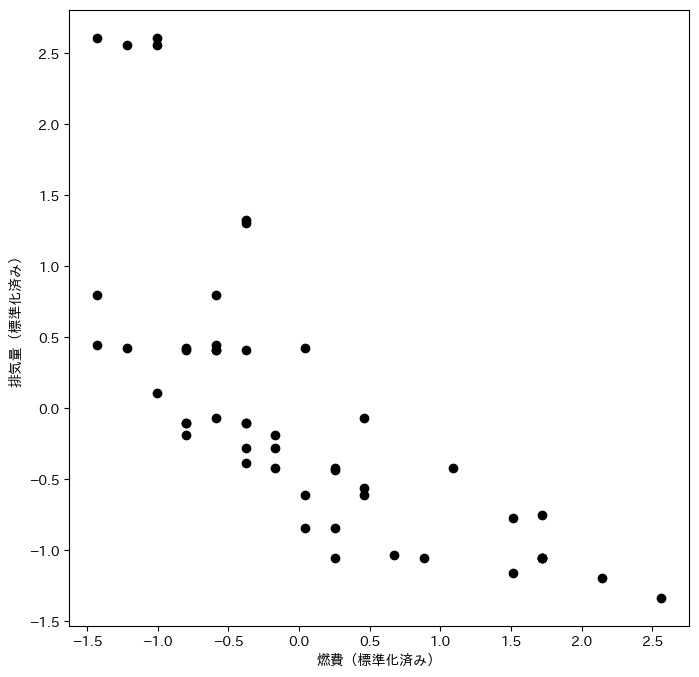

In [5]:
# データの標準化
X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# 二次元データのプロット
plt.figure(figsize=(8,8))
plt.scatter(X_norm[:,0], X_norm[:,1], color='k')
plt.xlabel('燃費（標準化済み）')
plt.ylabel('排気量（標準化済み）')

plt.show()

japanize_matplotlib ライブラリをインポートしているため，横軸と縦軸が日本語表示されています。  
（インポートされていない場合，文字化けします。）

## ステップ3: 階層クラスタリングのためのデータの準備  
ここから階層クラスタリングを行います。  

まず初期状態として，各サンプルをそれぞれクラスとして扱います。  
すなわち「クラス数 = サンプル数」です。  
この状態を以下のようにリストを使って定義します。

In [6]:
# クラスを空のリストとして定義
initial_class_list = []

# 各サンプルのデータを initial_class_list に追加（append関数）していく
for n in range(num_samples):
  initial_class_list.append(np.array([X_norm[n]]))

print(type(initial_class_list))
print(initial_class_list)

<class 'list'>
[array([[ 1.72220002, -1.05157316]]), array([[ 1.72220002, -0.75220185]]), array([[ 2.56187963, -1.33333439]]), array([[ 1.51228012, -1.15723362]]), array([[ 1.51228012, -0.76981193]]), array([[ 0.2527607 , -1.05157316]]), array([[ 1.72220002, -1.05157316]]), array([[ 0.67260051, -1.03396308]]), array([[ 0.0428408 , -0.84025224]]), array([[ 0.88252041, -1.05157316]]), array([[ 2.14203983, -1.19245377]]), array([[ 0.2527607 , -0.84025224]]), array([[-1.00675872,  2.61132282]]), array([[ 0.4626806 , -0.06540886]]), array([[-1.21667862,  2.55849259]]), array([[ 1.09244031, -0.41761039]]), array([[ 1.72220002, -1.05157316]]), array([[ 0.4626806 , -0.55849101]]), array([[-0.16707911, -0.18867939]]), array([[-0.37699901, -0.10062901]]), array([[ 0.2527607 , -0.41761039]]), array([[0.0428408 , 0.42767329]]), array([[-0.16707911, -0.27672978]]), array([[ 0.2527607 , -0.43522047]]), array([[-0.16707911, -0.41761039]]), array([[ 0.0428408 , -0.61132124]]), array([[-0.79683882,  0.

今，各クラスのデータをリスト型（numpyではなく，単なるリスト型。1回目の授業スライドのp.22参照）で定義しました。  
リストは「要素数=クラス数」の配列で定義されています。  
また，リスト内の各要素は numpy array型で定義されています。  
numpy arrayには，そのクラスに属するデータが格納されています。
numpy arrayの行数は，そのクラスに属するデータのサンプル数，列数は次元数に相当します。  

このリストを扱う練習として，クラス数，あるクラスに属するデータ，そしてそのサンプル数を取り出す方法を以下に記載します。

In [7]:
# クラス数はリストの要素数である。つまり len(initial_class_list) で得られる。
print('Number of classes: ' + str(len(initial_class_list)))

# n番目のクラスに属するデータは initial_class_list[n] で得られる。
class_data = initial_class_list[0]
print('data in class[0]:')
# class_data は numpy array型で定義されている。
print(type(class_data))
print(class_data)

# numpy arrayデータの行数は，このクラスに属するデータのサンプル数に相当する。
N, D = np.shape(class_data)
print('Number of samples in class[0]: ' + str(N))

Number of classes: 49
data in class[0]:
<class 'numpy.ndarray'>
[[ 1.72220002 -1.05157316]]
Number of samples in class[0]: 1


階層クラスタリングでは，近いクラス同士を一つにまとめる（マージする）ことで，クラス数を減らしていきます。  
例として，0番目のクラスと1番目のクラスをまとめてみます。  
これは以下の手順で行います。  
* 0番目のクラスのデータと1番目のクラスのデータを <font color=red>**`numpy.vstack`**</font>関数を使って縦に繋げる。
* <font color=red>**`append`**</font>関数を使って，繋げたデータをクラスリストの末尾に追加する。
* <font color=red>**`del`**</font>関数を使って，1番目のクラス，0番目のクラスを削除する。(このとき，**クラス番号の大きい方から順に削除すること。**)

In [8]:
# initial_class_list を class_list にコピー
class_list = initial_class_list.copy()

# class_list[0] と class_list[1] のデータを縦に繋げることで，統合する。
new_class = np.vstack([class_list[0], class_list[1]])

# 統合したクラスを class_list の末尾に追加する。
class_list.append(new_class)

# 統合に使われたクラスを削除する。
# 削除は，インデクスの大きいもの(この場合1)から順番に行うこと。先に0を消してしまうとインデクスがずれてしまうため。
del(class_list[1])
del(class_list[0])

# 統合後のクラス数
print('Number of classes: ' + str(len(class_list)))

# 末尾に追加したデータは class_list[-1]で得られる。(-1はリストの最後尾という意味)
class_data = class_list[-1]
print('marged class data:')
print(type(class_data))
print(class_data)

# numpy arrayデータの行数は，このクラスに属するデータのサンプル数に相当する。
N, D = np.shape(class_data)
print('Number of samples in marged class: ' + str(N))

Number of classes: 48
marged class data:
<class 'numpy.ndarray'>
[[ 1.72220002 -1.05157316]
 [ 1.72220002 -0.75220185]]
Number of samples in marged class: 2


統合した結果，クラス数が49から48に減り，統合したクラスのサンプル数が2になっているのが確認できます。  

## ステップ4: 最短距離法による階層クラスタリング  
クラスリストの準備と統合の実装方法について説明しましたので，  
これから最短距離法を使って階層クラスタリングを実行します。

まずユークリッド距離を計算する関数を以下に定義します。  
$d({\mathbf x}, {\mathbf y})=\sqrt{\sum_{d=1}^{D}(x_{d}-y_{d})^{2}}$  
（$x_{d}$はベクトル$\mathbf x$の$d$次元目の要素。$D$はベクトルの次元数。）

In [9]:
def euclidean_distance(x, y):
  '''
      ユークリッド距離を計算して出力する
      x, y: 距離を測りたい2個の多次元ベクトル
  '''
  dist = np.sum((x-y)**2)
  dist = np.sqrt(dist)
  return dist

続いて，クラス1とクラス2の最短距離を計算する関数を以下に定義します。  
${\rm shortest\_dist}({\mathbf c}_1, {\mathbf c}_2) = \min_{{\mathbf x}_1 \in {\mathbf c}_1, {\mathbf x}_2 \in {\mathbf c}_2} d({\mathbf x}_1, {\mathbf x}_2)$

In [10]:
def get_shortest_distance(class1, class2):
  '''
      クラス1(class1)とクラス2(class2)の最短距離を計算
      class1: NxDの配列(N:クラス1に属するデータのサンプル数, D:次元)
      class2: MxDの配列(M:クラス2に属するデータのサンプル数)
  '''
  # クラス1のサンプル数Nと次元数Dを得る
  N, D = np.shape(class1)
  # クラス2のサンプル数Mと次元数Dを得る
  M, D = np.shape(class2)

  # 距離マトリクスを作成
  # dist_matrix[n,m]にはクラス1に属するn番目のサンプルと
  # クラス2に属するm番目のサンプルとの距離が格納される
  dist_matrix = np.zeros([N, M])
  for n in range(N):
    for m in range(M):
      dist_matrix[n, m] = euclidean_distance(class1[n], class2[m])

  # 最短距離を求める
  min_dist = np.min(dist_matrix)

  return min_dist

定義した関数を使って，階層クラスタリングを行います。  
ここでは，クラス数が $K=3$ になるまで統合を繰り返すことにします。

In [11]:
K = 3

# クラスの初期状態をコピー
class_list = initial_class_list.copy()

while True:
  # 現在のクラス数を取得
  num_classes = len(class_list)

  # クラス数が K になっていれば終了
  if num_classes == K:
    break

  # 最も近いクラスのペアを見つける。
  min_dist = 9999999
  min_i = 0
  min_j = 0
  for i in range(num_classes - 1):
    for j in range(i+1, num_classes):
      # クラスi とクラスj の距離を計算
      class_i = class_list[i]
      class_j = class_list[j]
      dist = get_shortest_distance(class_i, class_j)

      if dist < min_dist:
        # 距離の最小値を更新
        min_dist = dist
        min_i = i
        min_j = j

  # 今，最も近いクラスのペアは min_i番目と min_j番目のクラスである。
  # これらを統合する。

  # classes[min_i]とclasses[min_j]を統合する。
  new_class = np.vstack([class_list[min_i], class_list[min_j]])

  # 統合したクラスをクラスリストの末尾に追加
  class_list.append(new_class)

  # 統合に使われたクラスを削除する。
  # (min_j > min_i のため，先にmin_iを削除するとインデクスがずれる。よってmin_jを先に削除してからmin_iを削除する)
  del(class_list[min_j])
  del(class_list[min_i])


結果をプロットしてみます。

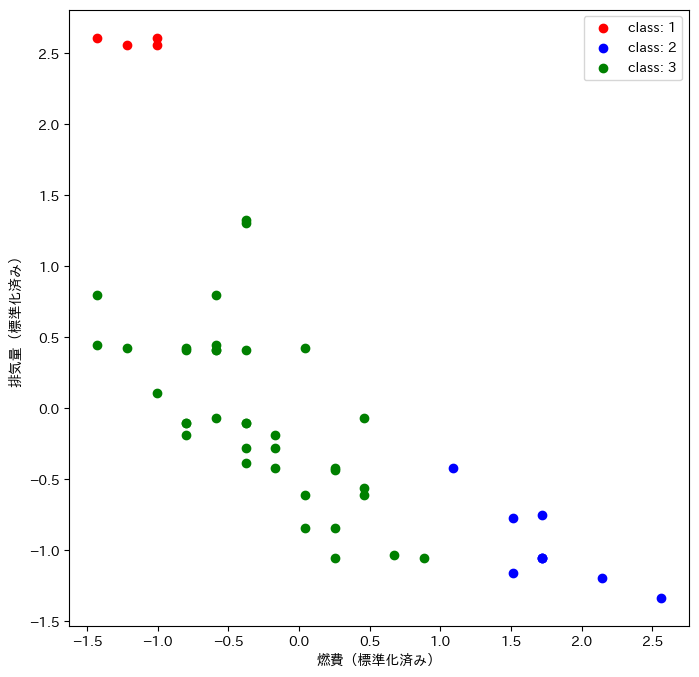

In [12]:
colors = ['r', 'b', 'g', 'c', 'm', 'y']
# 二次元データのプロット
plt.figure(figsize=(8,8))


for k in range(K):
  c = colors[k%6] # プロットの色を，クラス番号によって自動的に変える。

  # k番目のクラスデータを得る
  class_data = class_list[k]
  # プロット
  plt.scatter(class_data[:,0], class_data[:,1], color=c, label='class: '+str(k+1))
plt.xlabel('燃費（標準化済み）')
plt.ylabel('排気量（標準化済み）')
plt.legend()
plt.show()

結果から，排気量が多く燃費が悪い車がクラス1（赤），排気量が少なく燃費が良い車がクラス2（青），それ以外がクラス3（緑）というクラスに分けられていることが分かります。

## ステップ5: クラスの統合される様子を可視化  
階層クラスタリングによってクラスが統合されていく様子をアニメーションにしてみます。

In [13]:
from matplotlib import animation, rc
from IPython.display import HTML


# クラスの初期状態をコピー
class_list = initial_class_list.copy()
# color_list はクラス毎のプロット時の色を定義するリスト
color_list = []
for n in range(num_samples):
  color_list.append(0)

# アニメーション用
images = []
fig = plt.figure(figsize=(8,8))
cmap = plt.colormaps.get_cmap('tab20').colors #20色のカラーマップ

while True:
  # 現在のクラス数を取得
  num_classes = len(class_list)
  # プロット
  image_tmp = []
  for k in range(num_classes):
    # k番目のクラスデータを得る
    class_data = class_list[k]
    # 色の決定
    c_ind = color_list[k] % 20
    c_ind = 2*(c_ind % 10) + (c_ind // 10)
    if c_ind == 0:
      color = 'k'
    else:
      color = cmap[c_ind]
    # プロット
    img = plt.scatter(class_data[:,0], class_data[:,1], color=color)
    image_tmp.append(img)
  img = plt.text(1.0, 2.5, 'Num of classes: '+str(num_classes), size='x-large')
  image_tmp.append(img)
  images.append(image_tmp)

  # クラス数が 1 になっていれば終了
  if num_classes == 1:
    break

  # 最も近いクラスのペアを見つける。
  min_dist = 9999999
  min_i = 0
  min_j = 0
  for i in range(num_classes - 1):
    for j in range(i+1, num_classes):
      # クラスi とクラスj の距離を計算
      dist = get_shortest_distance(class_list[i], class_list[j])

      if dist < min_dist:
        # 距離の最小値を更新
        min_dist = dist
        min_i = i
        min_j = j

  # classes[min_i]とclasses[min_j]を統合する。
  new_class = np.vstack([class_list[min_i], class_list[min_j]])
  # 統合したクラスをクラスリストの末尾に追加
  class_list.append(new_class)

  # 統合したクラスの色を決める
  if color_list[min_i] == 0 and color_list[min_j] == 0:
    new_color = max(color_list) + 1
  elif color_list[min_i] != 0 and color_list[min_j] != 0:
    new_color = min([color_list[min_i], color_list[min_j]])
  else:
    new_color = max([color_list[min_i], color_list[min_j]])
  color_list.append(new_color)

  # 統合に使われたクラスを削除する。
  del(class_list[min_j])
  del(class_list[min_i])
  del(color_list[min_j])
  del(color_list[min_i])

plt.xlabel('燃費（標準化済み）')
plt.ylabel('排気量（標準化済み）')

# アニメーション作成
anim = animation.ArtistAnimation(fig, images, interval=1000)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
display(anim)

上記の結果を見ると，クラス数$K=4$のときでも，少数サンプルのクラスが存在しており，$K=3$でようやくまとまったクラスになっていることが分かります。  
$K=2$になると，排気量が多く燃費が悪いクラスと，それ以外のクラスに分かれていることが分かります。  

K-meansのような非階層クラスタリングでは分割クラス数$K$を変えるたびに処理を最初からやり直す必要があるのに対して，階層クラスタリングは一度実行しておけば，全ての分割数に対するクラスタリング結果が得られる点が長所の一つです。  
またそれにより，結果を確認しながら最適な分割数を見つけることができます。  

一方，非階層クラスタリングと比べて計算量が多い点は短所です。

## おまけ  
最短距離法の関数 `get_shortest_distance` で最小距離を計算している部分（np.min(dist_matrix)）を最大距離の計算（np.max(dist_matrix)）に置き換えるだけで，最長距離法の計算になります。  
興味のある方はこの関数を使って階層クラスタリングを行い，最短距離法の結果を見比べてみてください。

In [14]:
def get_longest_distance(class1, class2):
  '''
      クラス1(class1)とクラス2(class2)の最長距離を計算
      class1: NxDの配列(N:クラス1に属するデータのサンプル数, D:次元)
      class2: MxDの配列(M:クラス2に属するデータのサンプル数)
  '''
  # クラス1のサンプル数Nと次元数Dを得る
  N, D = np.shape(class1)
  # クラス2のサンプル数Mと次元数Dを得る
  M, D = np.shape(class2)

  # 距離マトリクスを作成
  # dist_matrix[n,m]にはクラス1に属するn番目のサンプルと
  # クラス2に属するm番目のサンプルとの距離が格納される
  dist_matrix = np.zeros([N, M])
  for n in range(N):
    for m in range(M):
      dist_matrix[n, m] = euclidean_distance(class1[n], class2[m])

  # 最長距離を求める
  max_dist = np.max(dist_matrix)

  return max_dist